# Import Needed Liberaries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Read (application_train, application_test) files

In [2]:
df = pd.read_csv('application_train.csv')
df1 = pd.read_csv('application_test.csv')

In [3]:
# make a label as to whether the instance belongs to train to test dataset
df['is_train'] = 1
df1['is_train'] = 0

# target for train data
trainY = df['TARGET']
df.drop('TARGET',axis=1,inplace=True)


# test id 
testID = df1['SK_ID_CURR']

data = pd.concat([df,df1],axis=0)

## Some Processing & Preparation on Files

In [4]:
print(df['DAYS_EMPLOYED'].mode()[0], df['DAYS_EMPLOYED'].isnull().sum(), sep='\n\n')

365243

0


In [5]:
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

In [4]:
def prepare_df(data):
    data['NEW_CREDIT_TO_ANNUITY_RATIO'] = data['AMT_CREDIT'] / data['AMT_ANNUITY']
    data['NEW_CREDIT_TO_GOODS_RATIO'] = data['AMT_CREDIT'] / data['AMT_GOODS_PRICE']
    data['NEW_ANNUITY_TO_INCOME_RATIO'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
    data['NEW_CREDIT_TO_INCOME_RATIO'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']

    data['CNT_FAM_MEMBERS'].fillna(data['CNT_FAM_MEMBERS'].median(),inplace=True)
    data['NEW_INC_PER_MEMB'] = data['AMT_INCOME_TOTAL'] / data['CNT_FAM_MEMBERS']
    data['NEW_INC_PER_CHLD'] = data['AMT_INCOME_TOTAL'] / (1 + data['CNT_CHILDREN'])

    data['NEW_EMPLOY_TO_BIRTH_RATIO'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
    data['NEW_CAR_TO_BIRTH_RATIO'] = data['OWN_CAR_AGE'] / data['DAYS_BIRTH']
    data['NEW_CAR_TO_EMPLOY_RATIO'] = data['OWN_CAR_AGE'] / data['DAYS_EMPLOYED']
    data['NEW_PHONE_TO_BIRTH_RATIO'] = data['DAYS_LAST_PHONE_CHANGE'] / data['DAYS_BIRTH']

    data['NEW_SOURCES_PROD'] = data['EXT_SOURCE_1'] * data['EXT_SOURCE_2'] * data['EXT_SOURCE_3']
    data['NEW_EXT_SOURCES_MEAN'] = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    data['NEW_SCORES_STD'] = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    data['NEW_SCORES_STD'].fillna(data['NEW_SCORES_STD'].mean(),inplace=True)
    
    return data

In [5]:
def remove_outliers(df):
#     d1 = df.select_dtypes(include='O')
#     df = df.select_dtypes(exclude='O')
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    df = df[~(df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))]
#     df = pd.concat([df, d1], axis=1)
    return df

In [6]:
def process_df(df, raw=False):
    df_nan = df[df.columns[df.isnull().any()]]
    df_na = df_nan[df_nan.columns[df_nan.isnull().mean()*100 < 50]]
    df_not_nan = df[df.columns[~df.isnull().any()]]
    df_na_cat = df_na.select_dtypes(include='O')
    for col in df_na_cat:
        df_na_cat[col].fillna(df_na_cat[col].mode()[0], inplace=True)
    df_na_num = df_na.select_dtypes(exclude='O')
    df_na_num = remove_outliers(df_na_num)
    df_na_num = df_na_num.fillna(df_na_num.mean())
#     if raw:
#         df = pd.concat([df_not_nan.drop('SK_ID_CURR', axis=1), df_na_cat, df_na_num], axis=1)
#     else:
    df = pd.concat([df_not_nan, df_na_cat, df_na_num], axis=1)
    df = pd.get_dummies(df, drop_first=True)
    return df

In [7]:
# examine fraction of missing value in each attribute
def missing_df(df):
        """
        return a data frame containing the statistics of missing value
        """
        
        total = df.isnull().sum().sort_values(ascending=False)
        fraction = 100 * total / df.shape[0]
        
        # keep to two decimal places
        fraction = fraction.apply(lambda x: round(x,2))
        
        df_missing = pd.concat([total,fraction], axis=1, keys=['Total','Fraction'])
        df_missing.index.name = 'Attributes'
        
        return df_missing
    
    
def cut_missing_fea(df, mis_threshold=50):
    """
    cut off features with ratio of missing values bigger than 60%
    """
    missing = missing_df(df)
    keep_fea = missing[missing['Fraction']<mis_threshold].index

    return df[keep_fea]


    
def prepare_data(df, group_var, prefix):
    
    # cut off featues with too much missing values
    df = cut_missing_fea(df)
    
    # if only one or two categories, factorize()
    for col in df:
        if df[col].dtype == 'object' and len(list(df[col].unique())) <= 2:
            df.loc[:,col], _ = pd.factorize(df[col])
    
    # one hot encoding if more than two categories, including Null
    df = pd.get_dummies(df,dummy_na=True)
    
    # compute sum, mean, std for each column
    d1 = df.drop([group_var],axis=1).groupby('SK_ID_CURR').agg(['sum','mean','std'])
    d1.columns = ['_'.join(col).strip('_ ') for col in d1.columns.values]
    d1.add_prefix(prefix+'_')
    
    # count group_var for each SK_ID_CURR
    d2 = df[['SK_ID_CURR',group_var]].groupby('SK_ID_CURR').count()
    
    # merge 
    df = pd.merge(d1,d2,left_index=True,right_index=True,how='left')
    
    # add prefix
    df = df.add_prefix(prefix+'_')
    
    return df.reset_index()
    

In [10]:
data = prepare_df(data)

## Processing & Merging the Files with the Data

In [11]:
bureau = pd.read_csv('bureau.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')

In [12]:
bureau_balance['STATUS'] = bureau_balance['STATUS'].replace(['C','X'],'0').apply(lambda x:int(x))
bb = bureau_balance['STATUS'].groupby(bureau_balance['SK_ID_BUREAU']).sum().to_frame()

# merge the sum of DPD
bureau = pd.merge(bureau,bb,left_on='SK_ID_BUREAU',right_index=True,how='left')

In [13]:
bureau = process_df(bureau)
#bureau_balance = process_df(bureau_balance)

In [14]:
bureau = prepare_data(bureau,group_var='SK_ID_BUREAU',prefix='bureau')
print("bureau.shape = ",bureau.shape)


# merge with  data
data = pd.merge(data,bureau,how='left')
data.shape

bureau.shape =  (305811, 92)


(356255, 226)

In [15]:
del bureau, bureau_balance

In [16]:
prev_app = pd.read_csv('previous_application.csv')

In [17]:
col_DAYS = []
for col in prev_app:
    if 'DAYS' in col:
        col_DAYS.append(col)

for col in col_DAYS:
    prev_app[col].replace(365243,np.nan,inplace=True)
del col_DAYS

In [18]:
prev_app = process_df(prev_app)
prev_app = prepare_data(prev_app,group_var='SK_ID_PREV',prefix='prev_app')
print("prev_app.shape = ",prev_app.shape)

data = pd.merge(data,prev_app,how='left')
data.shape

D:\Amr\Python36\python-3.6.5.amd64\lib\site-packages\pandas\core\generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


prev_app.shape =  (338857, 419)


(356255, 644)

In [19]:
pos_bal = pd.read_csv('POS_CASH_balance.csv')

In [20]:
pos_bal = process_df(pos_bal)
pos_bal = prepare_data(pos_bal,group_var='SK_ID_PREV',prefix='pos')
print("pos_bal.shape = ",pos_bal.shape)

# merge with  data
data = pd.merge(data,pos_bal,how='left')
data.shape

pos_bal.shape =  (337252, 41)


(356255, 684)

In [21]:
del pos_bal, prev_app

In [22]:
install_pay = pd.read_csv('installments_payments.csv')

In [23]:
install_pay = process_df(install_pay)
install_pay = prepare_data(install_pay,group_var='SK_ID_PREV',prefix='install')
print("install_pay.shape = ",install_pay.shape)

# merge with  data
data = pd.merge(data,install_pay,how='left')
data.shape

install_pay.shape =  (339587, 20)


(356255, 703)

In [24]:
credit_bal = pd.read_csv('credit_card_balance.csv')

In [25]:
credit_bal = process_df(credit_bal)
credit_bal = prepare_data(credit_bal,group_var='SK_ID_PREV',prefix='credit')
print("credit_bal.shape = ",credit_bal.shape)

# merge with  data
data = pd.merge(data,credit_bal,how='left')
data.shape

credit_bal.shape =  (103558, 80)


(356255, 782)

In [26]:
del credit_bal, install_pay

## Save the Data

In [28]:
data.to_csv("data.csv")

In [8]:
#data = pd.read_csv('data.csv')

## get_dummies for Catagorical Features

In [9]:
data = pd.get_dummies(data, drop_first=True)

# Split Data to Train & Test

In [10]:
ignore_features = ['SK_ID_CURR', 'is_train']
relevant_features = [col for col in data.columns if col not in ignore_features]
trainX = data[data['is_train'] == 1][relevant_features]
testX = data[data['is_train'] == 0][relevant_features]

In [37]:
# del data

## Impute the missing values

In [11]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")
imputer.fit(trainX)
trainX = imputer.transform(trainX)
testX = imputer.transform(testX)

## Scale the Data Using StandardScaler

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(trainX)
trainX, testX = scaler.transform(trainX), scaler.transform(testX)

## PCA (Not Great Option)

In [12]:
# from sklearn.decomposition import PCA

# pca = PCA()
# pca.fit(trainX)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

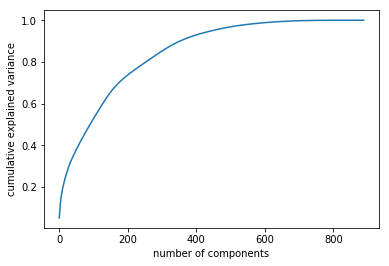

In [13]:
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance')
# plt.show()

In [15]:
# pca = PCA(n_components=400)
# trainX, testX = pca.fit_transform(trainX), pca.fit_transform(testX)

## Split Data to Train & Test

In [13]:
from sklearn.cross_validation import train_test_split

x_train, x_val, y_train, y_val = train_test_split(trainX, trainY, test_size=0.2, random_state=42)

D:\Amr\Python36\python-3.6.5.amd64\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
# Train on the training data
random_forest.fit(x_train,y_train)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.5min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=50, verbose=1, warm_start=False)

In [19]:
# Make predictions on the test data
Y_score = random_forest.predict_proba(x_val)
print(roc_auc_score(y_val,Y_score[:,1]))

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s


0.7266118010882912


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished


In [20]:
pred = random_forest.predict(x_val)
accuracy_score(pred,y_val)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished


0.9195811586426679

# Lightgbm

In [14]:
import lightgbm as lgb
lgb_train = lgb.Dataset(data=x_train, label=y_train)
lgb_eval = lgb.Dataset(data=x_val, label=y_val)

In [15]:
params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 
          'learning_rate': 0.01, 'num_leaves': 48, 'num_iteration': 5000, 'verbose': 0 ,
          'colsample_bytree':.8, 'subsample':.9, 'max_depth':7, 'reg_alpha':.1, 'reg_lambda':.1, 
          'min_split_gain':.01, 'min_child_weight':1}
model = lgb.train(params, lgb_train, valid_sets=lgb_eval, early_stopping_rounds=100, verbose_eval=20)

D:\Amr\Python36\python-3.6.5.amd64\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[20]	valid_0's auc: 0.740811
[40]	valid_0's auc: 0.74371
[60]	valid_0's auc: 0.746687
[80]	valid_0's auc: 0.749041
[100]	valid_0's auc: 0.75122
[120]	valid_0's auc: 0.753369
[140]	valid_0's auc: 0.755512
[160]	valid_0's auc: 0.757086
[180]	valid_0's auc: 0.759095
[200]	valid_0's auc: 0.760745
[220]	valid_0's auc: 0.762103
[240]	valid_0's auc: 0.763385
[260]	valid_0's auc: 0.764625
[280]	valid_0's auc: 0.76593
[300]	valid_0's auc: 0.767185
[320]	valid_0's auc: 0.768304
[340]	valid_0's auc: 0.76931
[360]	valid_0's auc: 0.770165
[380]	valid_0's auc: 0.771013
[400]	valid_0's auc: 0.77176
[420]	valid_0's auc: 0.772523
[440]	valid_0's auc: 0.773183
[460]	valid_0's auc: 0.773861
[480]	valid_0's auc: 0.77454
[500]	valid_0's auc: 0.775063
[520]	valid_0's auc: 0.775598
[540]	valid_0's auc: 0.776101
[560]	valid_0's auc: 0.77656
[580]	valid_0's auc: 0.776996
[600]	valid_0's auc: 0.777392
[620]	valid_0's auc: 0.777749
[640]	valid_0's auc

In [16]:
test_Y_score = model.predict(testX)
submit = pd.DataFrame({'SK_ID_CURR':testID.values, 'TARGET':test_Y_score})
submit.set_index('SK_ID_CURR')

,TARGET
SK_ID_CURR,
100001,0.029054
100005,0.135915
100013,0.021276
100028,0.040734
100038,0.171187
100042,0.039324
100057,0.009885
100065,0.056642
100066,0.012039


# Submit The Results

In [17]:
# Save the submission dataframe
submit.to_csv('lightgbm1.csv', index = False)

In [29]:
testID.values

array([100001, 100005, 100013, ..., 456223, 456224, 456250], dtype=int64)